In [3]:
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin
from transformers import BertTokenizer
from tokenizers import ByteLevelBPETokenizer, CharBPETokenizer
from transformers import AutoTokenizer
import os

# Set environment variables
os.environ["HF_DATASETS_OFFLINE"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"

def dummy_fun(doc):
    return doc

class SentencePieceTokenizer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='../input/huggingfacedebertav3variants/deberta-v3-base'):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, local_files_only=True)
        self.model_name = "SentencePieceTokenizer"
        self.max_len = 0
        
    def fit(self, X, y=None):
        # SentencePiece tokenizers do not require training, so fit method does nothing
        return self
    
    def transform(self, X, y=None):
        return  X.apply(self.tokenizer.tokenize)
    
# Define a custom transformer to integrate the WordPiece tokenizer into the sklearn pipeline
class WordPieceTokenizer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='../input/bert-base-uncased/'):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, local_files_only=True)
        self.model_name = "WordPieceTokenizer"
        self.max_len = 0 
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.apply(self.tokenizer.tokenize)

class BytePairTokenizer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='../input/roberta-base'):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, local_files_only=True)
        self.model_name = "BytePairTokenizer"
        self.max_len = 0
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.apply(self.tokenizer.tokenize)

class UnigramTokenizer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='../input/xlnetbasecased'):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, local_files_only=True)
        self.model_name = "UnigramTokenizer"
        self.max_len = 0
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.apply(self.tokenizer.tokenize)

# Load the data
df = pd.read_csv('/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv')

# Separate features and labels
X = df['text']
y = df['label']

def make_predictions_and_display_confusion_matrix(classifier_pipeline, test_data, test_labels, dataset_name):
    test_predictions = classifier_pipeline.predict(test_data)
    
    confusion_matrix_result = confusion_matrix(test_labels, test_predictions)
    
    disp = ConfusionMatrixDisplay(confusion_matrix_result, display_labels=["Not Generated", "Generated"])
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    
    accuracy = accuracy_score(test_labels, test_predictions)
    
    plt.title(f"Confusion Matrix on {dataset_name} Dataset - Accuracy: {accuracy:.2f}")
    plt.show()

sentencepiece_tokenizer_pipeline = Pipeline([
    ('tokenizer', SentencePieceTokenizer()),
    ('tfidf_vectorizer', TfidfVectorizer(ngram_range=(1, 3),tokenizer = dummy_fun,    preprocessor = dummy_fun,    token_pattern = None)),
    ('scaler', StandardScaler(with_mean=False)),  # StandardScaler after TF-IDF
    ('classifier', LogisticRegression(max_iter=1000))
])
    
# Create a pipeline with WordPiece tokenizer and Logistic Regression classifier
wordpiece_tokenizer_pipeline = Pipeline([
    ('tokenizer', WordPieceTokenizer()),
    ('tfidf_vectorizer', TfidfVectorizer(ngram_range=(1, 3),tokenizer = dummy_fun,    preprocessor = dummy_fun,    token_pattern = None)),
    ('scaler', StandardScaler(with_mean=False)),  # StandardScaler after TF-IDF
    ('classifier', LogisticRegression(max_iter=1000))
])

bytepair_tokenizer_pipeline = Pipeline([
    ('tokenizer', BytePairTokenizer()),
    ('tfidf_vectorizer', TfidfVectorizer(ngram_range=(1, 3),tokenizer = dummy_fun,    preprocessor = dummy_fun,    token_pattern = None)),
    ('scaler', StandardScaler(with_mean=False)),  # StandardScaler after TF-IDF
    ('classifier', LogisticRegression(max_iter=1000))
])

unigram_tokenizer_pipeline = Pipeline([
    ('tokenizer', UnigramTokenizer()),
    ('tfidf_vectorizer', TfidfVectorizer(ngram_range=(1, 3),tokenizer = dummy_fun,    preprocessor = dummy_fun,    token_pattern = None)),
    ('scaler', StandardScaler(with_mean=False)),  # StandardScaler after TF-IDF
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train the pipeliness on the entire dataset
sentencepiece_tokenizer_pipeline.fit(X, y)
wordpiece_tokenizer_pipeline.fit(X, y)
bytepair_tokenizer_pipeline.fit(X, y)
unigram_tokenizer_pipeline.fit(X, y)

# Combine the models using a soft ensemble with VotingClassifier
ensemble_classifier = VotingClassifier(
    estimators=[
        ('sentencepiece', sentencepiece_tokenizer_pipeline),
        ('wordpiece', wordpiece_tokenizer_pipeline),
        ('bytepair', bytepair_tokenizer_pipeline),
        ('unigram', unigram_tokenizer_pipeline)
    ],
    voting='soft'
)



/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


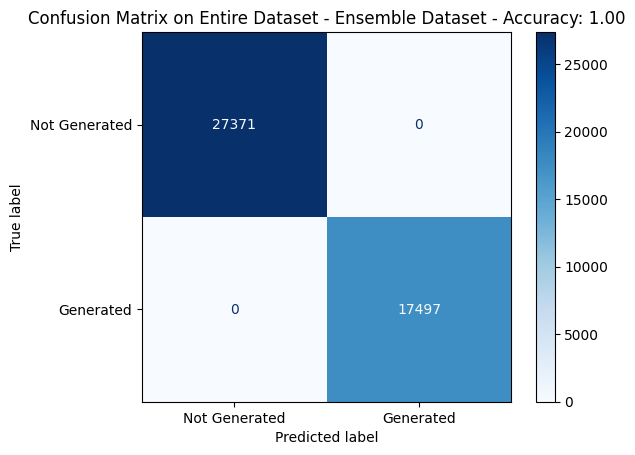

In [4]:
import numpy as np
class VotingClassifier_mine(object):
    """Stripped-down version of VotingClassifier that uses prefit estimators"""
    def __init__(self, estimators, voting='hard', weights=None):
        self.estimators = [e[1] for e in estimators]
        self.named_estimators = dict(estimators)
        self.voting = voting
        self.weights = weights

    def fit(self, X, y, sample_weight=None):
        raise NotImplementedError
        
    def predict(self, X):
        """ Predict class labels for X.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        Returns
        ----------
        maj : array-like, shape = [n_samples]
            Predicted class labels.
        """

        #check_is_fitted(self, 'estimators')
        if self.voting == 'soft':
            maj = np.argmax(self.predict_proba(X), axis=1)

        else:  # 'hard' voting
            predictions = self._predict(X)
            maj = np.apply_along_axis(lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions.astype('int'))
        return maj

    def _collect_probas(self, X):
        """Collect results from clf.predict calls. """
        return np.asarray([clf.predict_proba(X) for clf in self.estimators])

    def _predict_proba(self, X):
        """Predict class probabilities for X in 'soft' voting """
        if self.voting == 'hard':
            raise AttributeError("predict_proba is not available when"
                                 " voting=%r" % self.voting)
        #check_is_fitted(self, 'estimators')
        avg = np.average(self._collect_probas(X), axis=0, weights=self.weights)
        return avg

    @property
    def predict_proba(self):
        """Compute probabilities of possible outcomes for samples in X.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        Returns
        ----------
        avg : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.
        """
        return self._predict_proba

    def transform(self, X):
        """Return class labels or probabilities for X for each estimator.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        Returns
        -------
        If `voting='soft'`:
          array-like = [n_classifiers, n_samples, n_classes]
            Class probabilities calculated by each classifier.
        If `voting='hard'`:
          array-like = [n_samples, n_classifiers]
            Class labels predicted by each classifier.
        """
        #check_is_fitted(self, 'estimators')
        if self.voting == 'soft':
            return self._collect_probas(X)
        else:
            return self._predict(X)

    def _predict(self, X):
        """Collect results from clf.predict calls. """
        return np.asarray([clf.predict(X) for clf in self.estimators]).T
    
# Display confusion matrix for the ensemble on the entire dataset
# Combine the models using a soft ensemble with VotingClassifier
ensemble_classifier = VotingClassifier_mine(
    estimators=[
        ('sentencepiece', sentencepiece_tokenizer_pipeline),
        ('wordpiece', wordpiece_tokenizer_pipeline),
        ('bytepair', bytepair_tokenizer_pipeline),
        ('unigram', unigram_tokenizer_pipeline)
    ],
    voting='soft'
)

make_predictions_and_display_confusion_matrix(ensemble_classifier, X, y, "Entire Dataset - Ensemble")


In [5]:
df = pd.read_csv(f'/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
predictions = ensemble_classifier.predict_proba(df['text'])
result_df = pd.DataFrame({'id': df['id'], 'generated': predictions[:, 1]})
result_df.to_csv('/kaggle/working/submission.csv', index=False)